In [291]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import downscale as down

import pandas as pd
import geopandas as gpd
import scipy.stats as stats

from scipy.stats import weibull_min

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

# Weibull Parameters Comparison Between IMERG and Raingauge

## Data Periods

    * IMERG       : 01/06/2000 - 29/02/2024
    * Coast Level : 11/10/1987 - 30/11/2017
    * Low level   : 01/01/1987 - 10/11/2014
    * Medium level: 01/01/1984 - 21/11/2017
    * High level  : 01/07/1992 - 01/01/2023

In [194]:
# name, yy_s, yy_e = 'Coast Level', 2001, 2016
name, yy_s, yy_e = 'Low Level', 2001, 2013
# name, yy_s, yy_e = 'Medium Level', 2001, 2016
# name, yy_s, yy_e = 'High Level', 2001, 2022

print(f'Station   : {name}')
print(f'Start year: {yy_s}')
print(f'End year  : {yy_e}')

Station   : Low Level
Start year: 2001
End year  : 2013


## Haversine Distance to define the close IMERG pixel to Raingauge

In [195]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 # Earth radius in kilometers
    
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

## Load Veneto Geometry

In [196]:
Veneto = gpd.read_file(os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson'))

## Load IMERG data

In [197]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','IMERG_Italy_1dy_2000_06_01_2024_02_29.nc')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

lons = DATA.lon.values
lats = DATA.lat.values

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

dates = DATA['time'][:]
ntime = len(dates)

DATA

<xarray.Dataset> Size: 602MB
Dimensions:  (time: 4748, lat: 121, lon: 131)
Coordinates:
  * time     (time) datetime64[ns] 38kB 2001-01-01 2001-01-02 ... 2013-12-31
  * lat      (lat) float64 968B 35.95 36.05 36.15 36.25 ... 47.75 47.85 47.95
  * lon      (lon) float32 524B 5.95 6.05 6.15 6.25 ... 18.65 18.75 18.85 18.95
Data variables:
    PRE      (time, lat, lon) float64 602MB ...
Attributes:
    description:  IMERG daily data for Italy region

## Load Raingauge Data

In [198]:
rain_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
RAIN = pd.read_csv(os.path.join(rain_dir, 'QC_stations_coords_utm32.csv'), sep=';')

if name == 'Coast Level':
    Id_station = '338_RO_Co.csv'
elif name == 'Low Level':
    Id_station = '274_VR_Mo.csv'
elif name == 'Medium Level':
    Id_station = '343_BL_Fo.csv'
elif name == 'High Level':
    Id_station = '348_NP_Ro.csv'
else:
    print('ERROR: Id dont found')

print(f'{name} station')
CL_INFO = RAIN[RAIN['File_Name']==Id_station]

CL_RAIN = pd.read_csv(os.path.join(rain_dir, 'Dati_QC_30min', CL_INFO['File_Name'].values[0]), sep=';')
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN['yy'] = pd.to_datetime(CL_RAIN['dataora']).dt.year
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.month
CL_RAIN['dd'] = pd.to_datetime(CL_RAIN['dataora']).dt.day

CL_RAIN[CL_RAIN['valore']>200] = 0

CL_RAIN.tail(3)

Low Level station


,dataora,valore,qualita,yy,mm,dd
488397,2014-11-09 23:00:00,0.0,1.0,2014,11,9
488398,2014-11-09 23:30:00,0.0,1.0,2014,11,9
488399,2014-11-10 00:00:00,0.0,1.0,2014,11,10


## Raingauge Daily Acummulation

In [199]:
CL_RAIN = CL_RAIN[(CL_RAIN['yy']>=yy_s)&(CL_RAIN['yy']<=yy_e)]
CL_RAIN_daily = CL_RAIN.groupby(['yy', 'mm', 'dd'])['valore'].sum().reset_index()
CL_RAIN_daily

,yy,mm,dd,valore
0,2001,1,1,0.0
1,2001,1,2,9.4
2,2001,1,3,0.6
3,2001,1,4,8.4
4,2001,1,5,3.8
...,...,...,...,...
4743,2013,12,27,0.0
4744,2013,12,28,0.0
4745,2013,12,29,8.0
4746,2013,12,30,0.0


## Export Raingauge to xarray and Fit with Weinbull Distribution

In [200]:
OBS = xr.DataArray(CL_RAIN_daily['valore'].values,  coords={'time':dates}, dims=('time'))
NCW, YEARS = down.fit_yearly_weibull(OBS, thresh=1, maxmiss=36)

## Plot IMERG daily mean and Raingauge Position

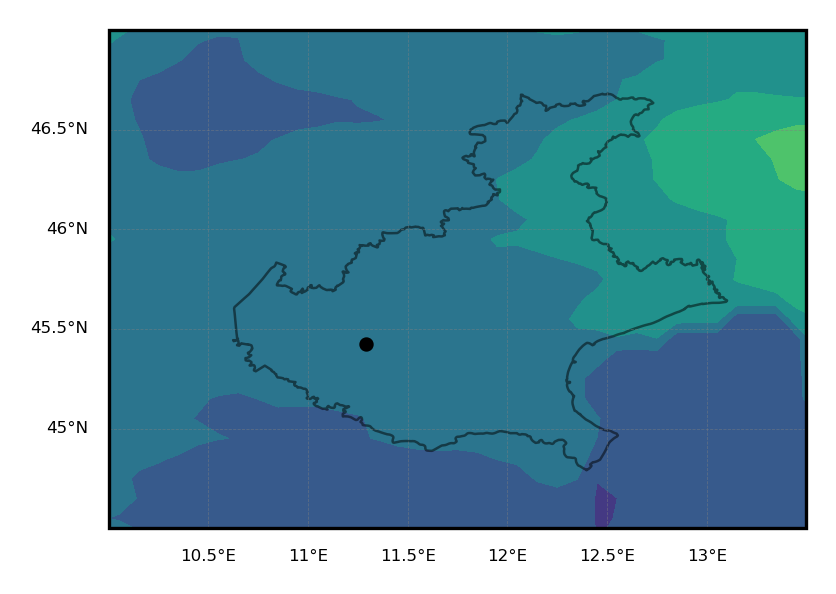

In [203]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10, 13.5, 44.5, 47], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

ax1.contourf(lon2d, lat2d, np.nanmean(DATA['PRE'],axis=0))
ax1.scatter(CL_INFO['Lon'], CL_INFO['Lat'], s=6, c='k', zorder=10)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

## Compute the nearest IMERG pixel to raingauge

In [204]:
distances = haversine(lat2d, lon2d, CL_INFO['Lat'].values[0], CL_INFO['Lon'].values[0])
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

clat = lats[min_index[0]]
clon = lons[min_index[1]]

IMERG_ML = DATA['PRE'].data[:,min_index[0],min_index[1]]

print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {CL_INFO['Lat'].values[0]}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {CL_INFO['Lon'].values[0]}')

Nearest IMERG lat: 45.45
Station lat       : 45.42333333

Nearest IMERG lon: 11.25
Station lon       : 11.28941667


## Define Parameters for Downscaling

In [226]:
thresh = 1
acf = 'mar'
toll=0.005
opt_method='genetic'
# dt = 3

Tr = np.array([5, 10, 20, 50, 80, 100])
Fi = 1-1/Tr
nyears = len(Tr)

npix = 3
buffer = 0.5*npix*dx

## Extract nearest IMERG pixel and convert in xarray

In [206]:
dset = np.swapaxes(DATA['PRE'],0,2).data[:,:,:]
xrs0 = xr.DataArray(dset,  coords={'lon':lons, 'lat':lats, 'time':dates}, dims=('lon', 'lat', 'time'))
xrs = xrs0.where(xrs0 >= -0.001)

## Define the neihbourhood space

In [207]:
eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

## Extract IMERG pixels using the neihbourhood 

In [208]:
box_3h = xrs.where(bcond, drop = True).load()
box_3h.shape

(3, 3, 4748)

## Start with the Dowscaling Process

In [209]:
downres = down.downscale(box_3h, Tr, thresh=thresh, L0=0.001, dt=24,
                            toll=toll, tscale=24,
                            acf=acf, save_yearly=True,
                            maxmiss=100, clat=clat, clon=clon,
                            opt_method=opt_method, plot=True)

Downscaling Intermittency
Taylor_Beta WARNING: not enough accuracy!
the time resolution of the coarse data might not be enough!
or try to increase the value of interp
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.00029966812863543797
differential_evolution step 2: f(x)= 0.00020503334155400104
differential_evolution step 3: f(x)= 0.00020496643651455408
Polishing solution with 'L-BFGS-B'
integration domain is zero
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters


# Compare the Weibull Parameters

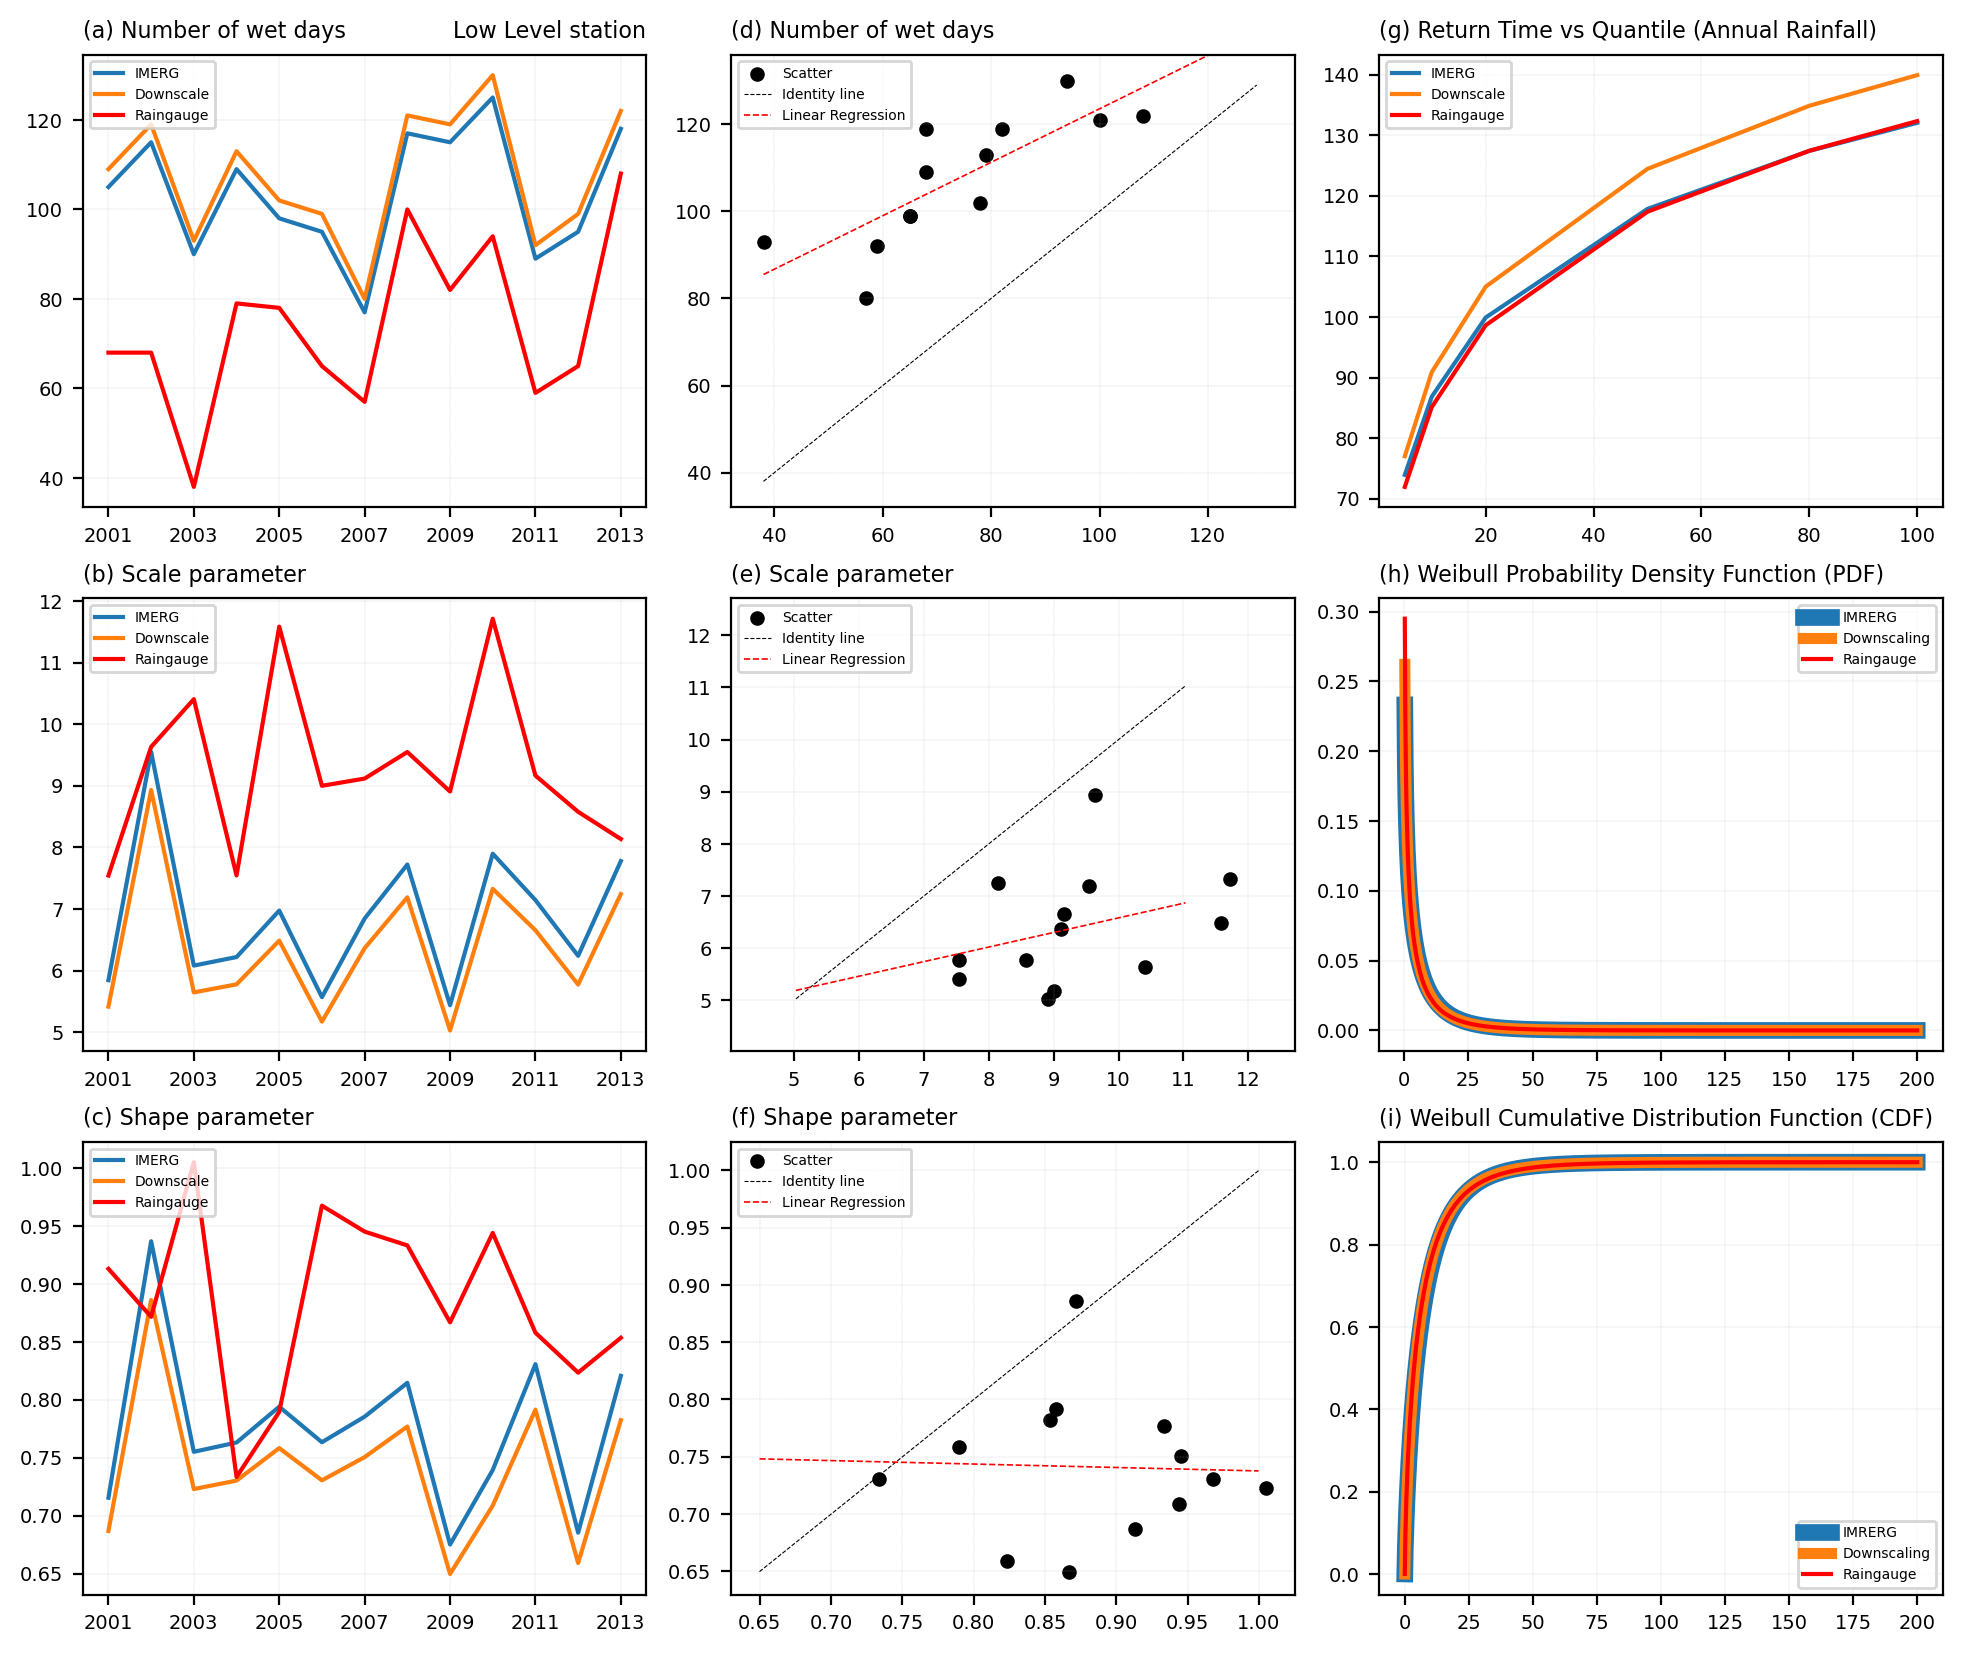

In [336]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(12,10),dpi=200)
gs = gridspec.GridSpec(3,3)

# ============================================================================================================================
# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])

ax1.plot(YEARS, downres['NYs'], label='IMERG')
ax1.plot(YEARS, downres['NYd'], label='Downscale')
ax1.plot(YEARS, NCW[:,0], c='r', label='Raingauge')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS.astype(int)[::2])
ax1.set_xticklabels(YEARS.astype(int)[::2])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(a) Number of wet days', loc='left', fontsize=8)
ax1.set_title(f'{name} station', loc='right', fontsize=8)

# ==============================================================================================
ax1 = plt.subplot(gs[1, 0])

ax1.plot(YEARS, downres['CYs'], label='IMERG')
ax1.plot(YEARS, downres['CYd'], label='Downscale')
ax1.plot(YEARS, NCW[:,1], c='r', label='Raingauge')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS.astype(int)[::2])
ax1.set_xticklabels(YEARS.astype(int)[::2])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(b) Scale parameter', loc='left', fontsize=8)

# ==============================================================================================
ax1 = plt.subplot(gs[2, 0])

ax1.plot(YEARS, downres['WYs'], label='IMERG')
ax1.plot(YEARS, downres['WYd'], label='Downscale')
ax1.plot(YEARS, NCW[:,2], c='r',label='Raingauge')

ax1.legend(fontsize=5, loc=2)
ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xticks(YEARS.astype(int)[::2])
ax1.set_xticklabels(YEARS.astype(int)[::2])
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.set_title('(c) Shape parameter', loc='left', fontsize=8)

# ============================================================================================================================
# ============================================================================================================================
max_ref = np.max((np.max(NCW[:,0]), np.max(downres['NYd'])))
min_ref = np.min((np.min(NCW[:,0]), np.min(downres['NYd'])))
ax1 = plt.subplot(gs[0, 1])

ax1.scatter(NCW[:,0], downres['NYd'], c='k', s=18, label='Scatter')
ax1.plot(np.arange(min_ref,max_ref),np.arange(min_ref,max_ref), '--', color='k', linewidth=0.4, label='Identity line')

slope, intercept, _, _, _ = stats.linregress(NCW[:,0], downres['NYd'])
ax1.plot(np.arange(min_ref,max_ref), slope*np.arange(min_ref,max_ref) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xlim(min_ref-6, max_ref+6)
ax1.set_ylim(min_ref-6, max_ref+6)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=2)
ax1.set_title('(d) Number of wet days', loc='left', fontsize=8)

# ==============================================================================================
max_ref = np.max((np.max(NCW[:,1]), np.max(downres['CYd'])))
min_ref = np.min((np.min(NCW[:,1]), np.min(downres['CYd'])))
ax1 = plt.subplot(gs[1, 1])

ax1.scatter(NCW[:,1], downres['CYd'], c='k', s=18, label='Scatter')
ax1.plot(np.arange(min_ref,max_ref),np.arange(min_ref,max_ref), '--', color='k', linewidth=0.4, label='Identity line')

slope, intercept, _, _, _ = stats.linregress(NCW[:,1], downres['CYd'])
ax1.plot(np.arange(min_ref,max_ref), slope*np.arange(min_ref,max_ref) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xlim(min_ref-1, max_ref+1)
ax1.set_ylim(min_ref-1, max_ref+1)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=2)
ax1.set_title('(e) Scale parameter', loc='left', fontsize=8)

# ==============================================================================================
max_ref = np.max((np.max(NCW[:,2]), np.max(downres['WYd'])))
min_ref = np.min((np.min(NCW[:,2]), np.min(downres['WYd'])))
ax1 = plt.subplot(gs[2, 1])

ax1.scatter(NCW[:,2], downres['WYd'], c='k', s=18, label='Scatter')
ax1.plot(np.arange(min_ref,max_ref, 0.01),np.arange(min_ref,max_ref, 0.01), '--', color='k', linewidth=0.4, label='Identity line')

slope, intercept, _, _, _ = stats.linregress(NCW[:,2], downres['WYd'])
ax1.plot(np.arange(min_ref,max_ref, 0.01), slope*np.arange(min_ref,max_ref, 0.01) + intercept, '--', color='r', linewidth=0.6, label='Linear Regression')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.set_xlim(min_ref-0.02, max_ref+0.02)
ax1.set_ylim(min_ref-0.02, max_ref+0.02)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=2)
ax1.set_title('(f) Shape parameter', loc='left', fontsize=8)

# ============================================================================================================================
# ============================================================================================================================
quant, flags = down.mev_quant(Fi, 0, NCW[:,0], NCW[:,1], NCW[:,2], thresh=1)
ax1 = plt.subplot(gs[0, 2])
ax1.plot(Tr, downres['mev_s'], label='IMERG')
ax1.plot(Tr, downres['mev_d'], label='Downscale')
ax1.plot(Tr, quant, c='r', label='Raingauge')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=2)
ax1.set_title('(g) Return Time vs Quantile (Annual Rainfall)', loc='left', fontsize=8)

# ==============================================================================================
x = np.linspace(0, 200, 1000)
OBS_N, OBS_scale, OBS_shape = down.wei_fit(OBS.data)
OBS_pdf = weibull_min.pdf(x, OBS_shape, scale=OBS_scale)
IMERG_pdf = weibull_min.pdf(x, downres['Ws'], scale=downres['Cs'])
DOWN_pdf = weibull_min.pdf(x, downres['Wd'], scale=downres['Cd'])
ax1 = plt.subplot(gs[1, 2])
ax1.plot(x, IMERG_pdf, linewidth=6, label='IMRERG')
ax1.plot(x, DOWN_pdf, linewidth=4, label='Downscaling')
ax1.plot(x, OBS_pdf,  c='r', label='Raingauge')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=0)
ax1.set_title('(h) Weibull Probability Density Function (PDF)', loc='left', fontsize=8)

# ==============================================================================================
x = np.linspace(0, 200, 1000)
OBS_cdf = weibull_min.cdf(x, OBS_shape, scale=OBS_scale)
IMERG_cdf = weibull_min.cdf(x, downres['Ws'], scale=downres['Cs'])
DOWN_cdf = weibull_min.cdf(x, downres['Wd'], scale=downres['Cd'])
ax1 = plt.subplot(gs[2, 2])
ax1.plot(x, IMERG_cdf, linewidth=6, label='IMRERG')
ax1.plot(x, DOWN_cdf, linewidth=4, label='Downscaling')
ax1.plot(x, OBS_cdf,  c='r', label='Raingauge')

ax1.grid(linewidth=0.1, linestyle='--')
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)

ax1.legend(fontsize=5, loc=0)
ax1.set_title('(i) Weibull Cumulative Distribution Function (CDF)', loc='left', fontsize=8)
# ============================================================================================================================
# ============================================================================================================================
plt.subplots_adjust(hspace=0.2,wspace=0.15)